In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import pydotplus 
from pydotplus import InvocationException
import graphviz
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = '/Users/sapta/Desktop/archive'
WORKING_DIR = '/Users/sapta'


In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [4]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8096 [00:00<?, ?it/s]

In [5]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
# preprocess the text
clean(mapping)

In [13]:
# after preprocess of text
mapping['104136873_5b5d41be75']

['startseq people sit on the mountainside and check out the view endseq',
 'startseq three people are on hilltop overlooking green valley endseq',
 'startseq three people hang out on top of big hill endseq',
 'startseq three people overlook green valley endseq',
 'startseq three people rest on ledge above the moutains endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8485

In [19]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

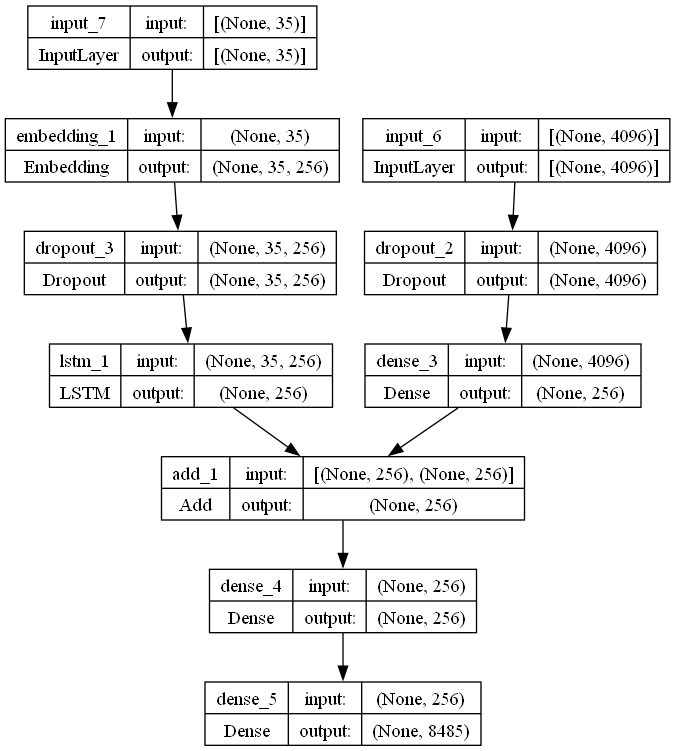

In [60]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 35
batch_size = 60
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

 29/121 [======>.......................] - ETA: 5:19 - loss: 2.8301

In [24]:
model.save(WORKING_DIR+'/Desktop/archive')
model.save('mycaptionmodel1.keras')

INFO:tensorflow:Assets written to: /Users/sapta/Desktop/archive\assets


INFO:tensorflow:Assets written to: /Users/sapta/Desktop/archive\assets


#genarate caption for images

In [1]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [2]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [3]:
import nltk
from nltk.translate.bleu_score import corpus_bleu

# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

NameError: name 'tqdm' is not defined

visualize the result

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")

In [ ]:
generate_caption("109202801_c6381eef15.jpg")

In [ ]:
generate_caption("35506150_cbdb630f4f.jpg")

In [ ]:
generate_caption("44129946_9eeb385d77.jpg")

In [ ]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [ ]:
image_path = '/Users/sapta/Desktop/archive/Images/12345678.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)




In [ ]:
from deep_translator import GoogleTranslator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

# Function to generate caption for an image
def generate_caption(image_path, vgg_model, model, tokenizer, max_length):
    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract features
    feature = vgg_model.predict(image, verbose=0)

    # Generate caption
    caption = predict_caption(model, feature, tokenizer, max_length)
    return caption

# Function to translate a caption into multiple languages
def translate_caption(caption, target_languages):
    translations = {}
    for lang in target_languages:
        translator_instance = GoogleTranslator(source='auto', target=lang)
        translation = translator_instance.translate(caption)
        translations[lang] = translation
    return translations

# Example usage
image_path = '/Users/sapta/Desktop/archive/Images/12345678.jpg'
target_languages = [ 'en','hi', 'bn', 'te', 'mr', 'ta', 'ur', 'gu', 'kn'  ]  

# Generate caption for the image
caption = generate_caption(image_path, vgg_model, model, tokenizer, max_length)

# Translate the caption into multiple languages
translated_captions = translate_caption(caption, target_languages)

# Print translated captions
for lang, translated_caption in translated_captions.items():
    print(f"{lang}: {translated_caption}")


In [ ]:
from deep_translator import GoogleTranslator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

# Function to generate caption for an image
def generate_caption(image_path, vgg_model, model, tokenizer, max_length):
    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract features
    feature = vgg_model.predict(image, verbose=0)

    # Generate caption
    caption = predict_caption(model, feature, tokenizer, max_length)
    return caption

# Function to translate a caption into a single target language
def translate_caption(caption, target_language):
    translator_instance = GoogleTranslator(source='auto', target=target_language)
    translation = translator_instance.translate(caption)
    return translation

# Example usage
image_path = '/Users/sapta/Desktop/archive/Images/12345678.jpg'

# Prompt the user to enter the target language
target_language = input("Enter the target language (e.g., 'hi' for Hindi, 'bn' for Bengali, etc.): ")

# Check if the target language is supported
supported_languages = ['hi', 'bn', 'te', 'mr', 'ta', 'ur', 'gu', 'kn']
if target_language in supported_languages:
    # Generate caption for the image
    caption = generate_caption(image_path, vgg_model, model, tokenizer, max_length)

    # Translate the caption to the specified target language
    translated_caption = translate_caption(caption, target_language)

    # Print translated caption
    print(f"{target_language}: {translated_caption}")
else:
    print("Invalid target language. Please specify one of the supported languages.")


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to display the image
def display_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
# Display the image
display_image(image_path)

# Print translated captions
for lang, translated_caption in translated_captions.items():
    print(f"{lang}: {translated_caption}")


In [ ]:
from deep_translator import GoogleTranslator
from gtts import gTTS
import os

# Function to generate audio for translated captions
def generate_audio(translated_captions):
    for lang, translated_caption in translated_captions.items():
        tts = gTTS(text=translated_caption, lang=lang, slow=False)
        audio_file = f"{lang}_caption.mp3"
        tts.save(audio_file)
        print(f"Audio generated for {lang} caption")

# Example usage
# Generate audio for translated captions
generate_audio(translated_captions)


In [ ]:
from deep_translator import GoogleTranslator
from gtts import gTTS
import os
import pygame

# Function to generate audio for translated captions
def generate_audio(translated_captions):
    for lang, translated_caption in translated_captions.items():
        tts = gTTS(text=translated_caption, lang=lang, slow=False)
        audio_file = f"{lang}_caption.mp3"
        tts.save(audio_file)
        print(f"Audio generated for {lang} caption")
        # Play the audio
        pygame.mixer.init()
        pygame.mixer.music.load(audio_file)
        pygame.mixer.music.play()
        while pygame.mixer.music.get_busy():
            pygame.time.Clock().tick(10)

# Example usage
# Generate audio for translated captions
generate_audio(translated_captions)
